# Proyecto Final IA 2023-1

Integrantes:
- Fabian Perez
- Paula Arguello
- Manuel Herrera

In [4]:
carpeta_proyecto = "/content/drive/MyDrive/proyecto" #@param

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## librerias

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import random
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

## dataset

In [2]:
output = "/content/dataset.csv"
gdown.download("https://drive.google.com/uc?id=1x1RMBr4RwyOQ3uAhqYaczvqb79Nakm3z", output)

Downloading...
From: https://drive.google.com/uc?id=1x1RMBr4RwyOQ3uAhqYaczvqb79Nakm3z
To: /content/dataset.csv
100%|██████████| 33.7M/33.7M [00:00<00:00, 45.2MB/s]


'/content/dataset.csv'

In [3]:
#@title utils for data cleaning
def data_clean(df):
  # get dummies de los tiempos
  df.drop(['time_signature'],axis=1, inplace=True)
  df['mode'] = np.where(df['mode']=='Major', 1, 0)

  df['duration_ms'] = df['duration_ms'] / 1000
  df.rename(columns={'duration_ms': 'duration_s'}, inplace=True)

  genre_counts = df['genre'].value_counts()# le agregue esto
  genres = genre_counts.nlargest(10).index.tolist()# esto
  df = df[df['genre'].isin(genres)]# y esto

  df.drop_duplicates(subset=['track_id'], keep='first',inplace=True)
  df = df.fillna(df.mean())

  return df

def organize_target(df, target):
  df = df.copy()
  if target == "genre":
    df.drop(['artist_name','track_name','track_id','key','mode',],axis=1, inplace=True)
  if target == "popularity":
    df.drop(['genre','artist_name','track_name','track_id','key'],axis=1, inplace=True)
    df.drop(['duration_s','mode','tempo','acousticness','instrumentalness','liveness'], axis=1, inplace=True)
  if target == "sentyment":
    df.drop(['artist_name','track_name','track_id','key', 'genre'],axis=1, inplace=True)

  return df

In [96]:
df = pd.read_csv(output)
df = data_clean(df)

data_spotify = df.copy()
data_spotify.drop(['artist_name','track_name','track_id','key'], axis=1, inplace=True)

label_encoder = LabelEncoder()
data_spotify['genre'] = label_encoder.fit_transform(data_spotify['genre'])

<ipython-input-3-516451dbaaac>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['track_id'], keep='first',inplace=True)
<ipython-input-3-516451dbaaac>:15: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [97]:
data_spotify.head(2)

,genre,popularity,acousticness,danceability,duration_s,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
22169,2,96,0.1530,0.841,212.500,0.798,0.000003,0.0618,-4.206,0,0.2290,95.948,0.591
22170,2,82,0.0771,0.652,205.947,0.713,0.000010,0.1440,-5.311,1,0.0368,100.023,0.152


## Prediccion de valores

### Genero

In [7]:
df_genre = organize_target(df, 'genre')

X = df_genre.drop('genre', axis=1)
y_word_genre = df_genre['genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_word_genre)

scaler_genre = StandardScaler()
X = scaler_genre.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [8]:
def create_model(lr, batch_size, activation, dropout):

    model = Sequential()
    model.add(Dense(256, activation=activation, input_dim=X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(512, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(256, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

    return model

In [ ]:
lr = [0.0005, 0.001, 0.005]
batch_size = [128, 256, 320]
activation = ['relu']
dropout = [0.1, 0.2, 0.4]

param_grid = {'lr': lr, 'batch_size': batch_size, 'activation': activation, 'dropout': dropout}
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search_result = grid_search.fit(X_train, y_train)


print('Mejores hiperparámetros:', grid_search_result.best_params_)

In [9]:
model_test_genre = create_model(lr=0.001, batch_size=128, activation='relu', dropout=0.1)

history = model_test_genre.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
loss, accuracy = model_test_genre.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

Epoch 1/500
476/476 [==============================] - 13s 5ms/step - loss: 1.0234 - accuracy: 0.6366 - val_loss: 0.9526 - val_accuracy: 0.6527
Epoch 2/500
476/476 [==============================] - 2s 4ms/step - loss: 0.9442 - accuracy: 0.6579 - val_loss: 0.9259 - val_accuracy: 0.6592
Epoch 3/500
476/476 [==============================] - 2s 4ms/step - loss: 0.9196 - accuracy: 0.6647 - val_loss: 0.9160 - val_accuracy: 0.6657
Epoch 4/500
476/476 [==============================] - 2s 4ms/step - loss: 0.9051 - accuracy: 0.6685 - val_loss: 0.9046 - val_accuracy: 0.6684
Epoch 5/500
476/476 [==============================] - 2s 4ms/step - loss: 0.8932 - accuracy: 0.6736 - val_loss: 0.8966 - val_accuracy: 0.6712
Epoch 6/500
476/476 [==============================] - 3s 6ms/step - loss: 0.8823 - accuracy: 0.6769 - val_loss: 0.8872 - val_accuracy: 0.6744
Epoch 7/500
476/476 [==============================] - 2s 5ms/step - loss: 0.8761 - accuracy: 0.6795 - val_loss: 0.8919 - val_accuracy: 0.673

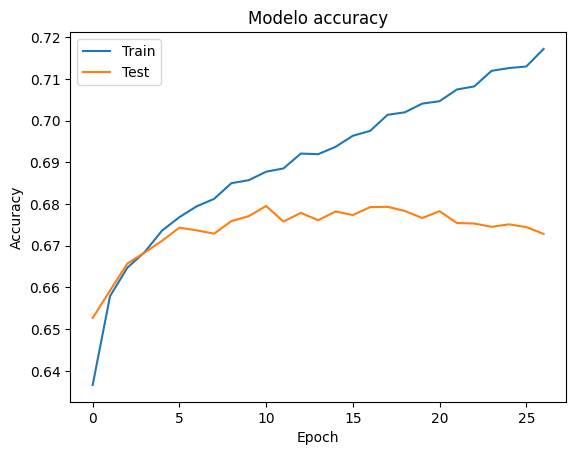

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# cargar modelo con pesos entrenados
model_test_genre = tf.keras.models.load_model(carpeta_proyecto +  "/model_10genres.h5")

1/1 [==============================] - 0s 76ms/step

# predicha: [8] Clase predicha: ['Comedy']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Popularidad

<Axes: >

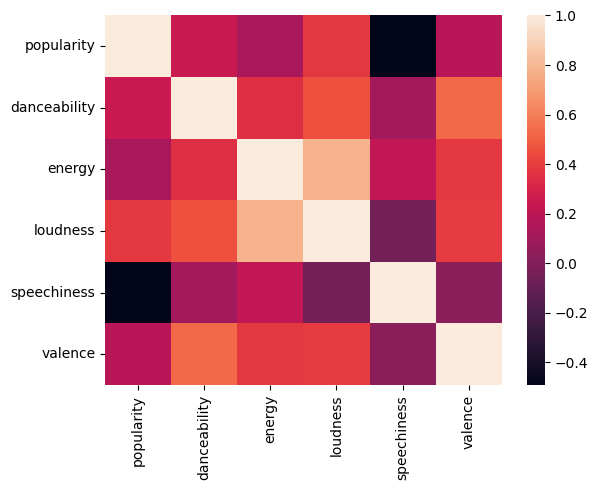

In [11]:
df_popularity = organize_target(df, 'popularity')

correlation_mat = df_popularity.corr()
sns.heatmap(correlation_mat)


In [12]:
X = df_popularity.drop('popularity', axis=1)
y_word_popularity = df_popularity['popularity']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_word_popularity)

scaler_popularity = StandardScaler()
X = scaler_popularity.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

y_test = y_test/100
y_train = y_train/100
print(y_test.shape)

(15225,)


In [16]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.metrics import R2Score


model_popularity = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[5]),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_popularity.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mse',
              metrics="mae")

history = model_popularity.fit(X_train, y_train,epochs=20, batch_size=20)

test_loss, test_acc = model_popularity.evaluate(X_test, y_test)

probs = model_popularity.predict(X_test)
preds = np.argmax(probs, axis=1)

Epoch 1/20
3045/3045 [==============================] - 14s 4ms/step - loss: 0.0138 - mae: 0.0914
Epoch 2/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0134 - mae: 0.0897
Epoch 3/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0133 - mae: 0.0892
Epoch 4/20
3045/3045 [==============================] - 10s 3ms/step - loss: 0.0132 - mae: 0.0889
Epoch 5/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0132 - mae: 0.0888
Epoch 6/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0131 - mae: 0.0886
Epoch 7/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0131 - mae: 0.0884
Epoch 8/20
3045/3045 [==============================] - 13s 4ms/step - loss: 0.0131 - mae: 0.0884
Epoch 9/20
3045/3045 [==============================] - 11s 3ms/step - loss: 0.0130 - mae: 0.0882
Epoch 10/20
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0130 - mae: 0.0882
Epoch 11/20
3045/30

Exception ignored in: <function _xla_gc_callback at 0x78ec06cb9cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


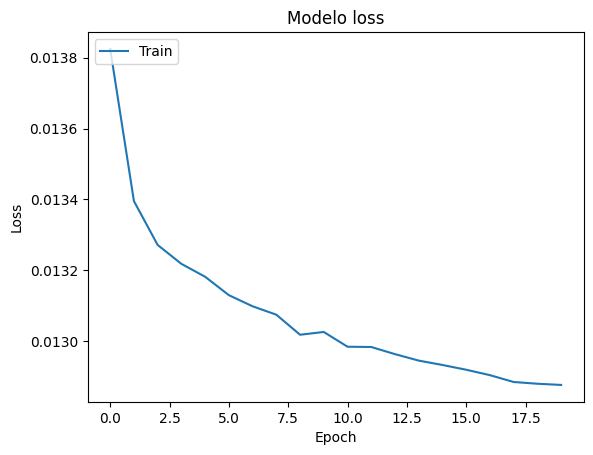

In [20]:
# Plot the loss in the model
plt.plot(history.history['loss'])
plt.title('Modelo loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

### Sentimiento

In [101]:
df_sentyment = organize_target(df, 'sentyment')

In [102]:
def sentyment(row):

    if row['valence'] < 0.3 and row['energy'] <= 0.5 or row['valence'] <= 0.5 and row['energy'] < 0.3:
        return 'sad'

    elif row['valence'] >= 0.7 and row['energy'] >= 0.5 or row['valence'] >= 0.5 and row['energy'] > 0.7:
        return 'happy'

    elif row['valence'] >= 0.3 and row['valence'] <= 0.7 and row['energy'] >= 0.3 and row['energy'] <= 0.7:
        return 'neutral'

    elif row['valence'] <= 0.3 and row['energy'] >= 0.5 or row['valence'] >= 0.3 and row['energy'] >= 0.7:
        return 'angry'

    elif row['valence'] >= 0.7 and row['energy'] <= 0.5 or row['valence'] >= 0.5 and row['energy'] <= 0.3:
        return 'calm'


df_sentyment['sentyment'] = df_sentyment.apply(lambda row: sentyment(row), axis=1)


df_sentyment['sentyment'].value_counts()

angry      20433
sad        17977
neutral    17881
happy      16876
calm        2958
Name: sentyment, dtype: int64

In [103]:
X = df_sentyment.drop('sentyment', axis=1)
y_word_sentyment = df_sentyment['sentyment']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_word_sentyment)
data_spotify['sentyment'] = y

scaler_sentyment = StandardScaler()
X = scaler_sentyment.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [24]:
# view the importance of each feature
model_sentytment = DecisionTreeClassifier( criterion='gini', max_depth=None, min_samples_leaf=1)

model_sentytment.fit(X_train,y_train)
model_sentytment.score(X_test,y_test)

1.0

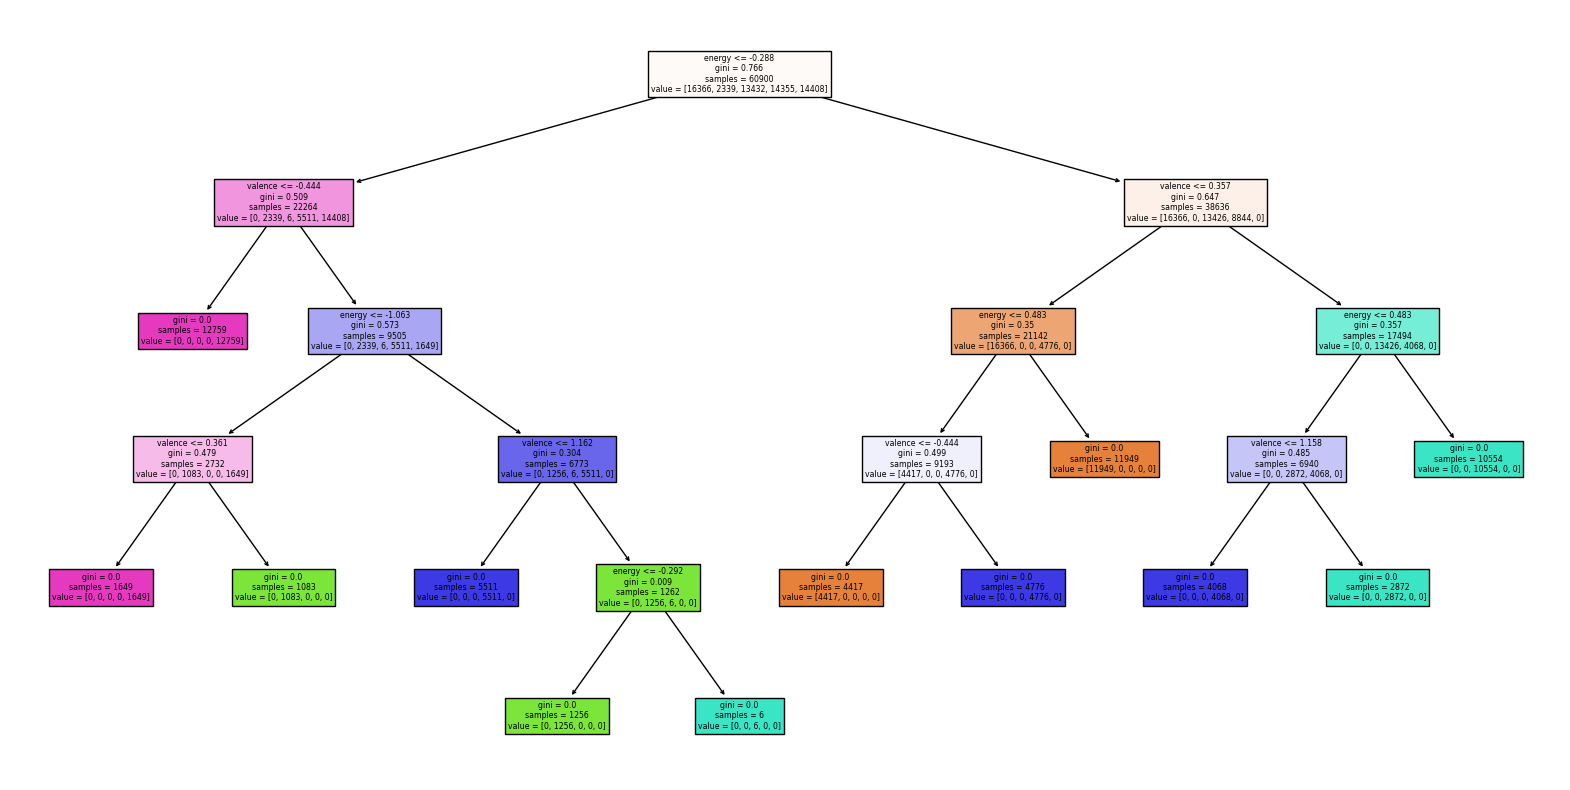

In [25]:
# plot tree
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(model_sentytment, feature_names=df_sentyment.columns, filled=True)#class_names=dataset_sampled.sentyment.unique(), filled=True)
plt.show()

## Recomedacion de canciones

In [26]:
%pip install spotipy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 5.3 MB/s eta 0:00:00


### credenciales

In [27]:

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np

cid = '9eee95ac954342ac8f91f9c64f993ab6'
secret = 'aed6af60f13e442eaf9f4c2e7d882a5a'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# get info from tracks
def get_track_info(track):

    uri = track['uri']


    track_features = sp.audio_features(uri)[0]
    track_features['duration_s'] = track_features['duration_ms'] / 1000
    track_features['popularity'] = track['popularity']

    del track_features['duration_ms'], track_features['track_href'], track_features['analysis_url'], track_features['id'], track_features['uri'], track_features['key'], track_features['type'], track_features['time_signature']


    return  track_features


### obtener canciones

se predecira una cancion por cada cancion de la playlist, como maximo se agregaran 5 canciones por playlist

In [76]:
playlist_link = 'https://open.spotify.com/playlist/5YU8QGkDdGuKEph4qvnoC6?si=0ed62218e1c84461'

playlist_URI = playlist_link.split("/")[-1].split("?")[0]

results = sp.playlist_tracks(playlist_URI)

track_uris = []
for x in sp.playlist_tracks(playlist_URI)["items"][:5]:
    track_uris.append(x['track'])

info = get_track_info(track_uris[0])
info = np.array(list(info.values()), dtype=np.float32)

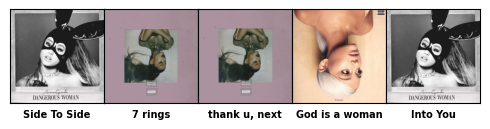

In [107]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_cover_art(playlist_df,columns):

    plt.figure(figsize=(5,5) , facecolor='#FFFFFF')

    for i, track in enumerate(playlist_df):
        plt.subplot(1, columns, i + 1)
        image = io.imread(track['album']['images'][0]['url'])
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s=''
        plt.xlabel(track['name'], fontsize = 7, fontweight='bold')
        plt.tight_layout(h_pad = 3, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

visualize_cover_art(track_uris,5)

In [90]:
n = 0
get_track_info(track_uris[n])

{'danceability': 0.65,
 'energy': 0.736,
 'loudness': -5.84,
 'mode': 0,
 'speechiness': 0.229,
 'acousticness': 0.0513,
 'instrumentalness': 0,
 'liveness': 0.235,
 'valence': 0.612,
 'tempo': 159.174,
 'duration_s': 226.16,
 'popularity': 79}

### prediccion de genero, popularidad y sentyment para cada cancion

In [91]:
info_genre = info[[11,5,0,10,1,6,7,2,3,4,9]]

X = scaler_genre.transform(info_genre.reshape(1, -1))

prediction = model_test_genre.predict(X)
clase_ = np.argmax(prediction, axis=1)
clase_word = y_word_genre.unique()[clase_]

# sentyment
info_sentyment = info[[11,5,0,10,1,6,7,2,3,4,9,8]]

X = scaler_sentyment.transform(info_sentyment.reshape(1, -1))
prediction_ = model_sentytment.predict(X)
clase = y_word_sentyment.unique()[prediction_[0]]

# popularity
info_popularity = info[[0,1,2,4,8]]

X = scaler_popularity.transform(info_popularity.reshape(1, -1))

prediction = model_popularity.predict(X)


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [98]:
info = get_track_info(track_uris[n])

info['genre'] = clase_[0]
info['sentyment'] = prediction_[0]
info['popularity'] = prediction*(100)

info = np.array(list(info.values()), dtype=np.float32)

info = info[[12,11,5,0,10,1,6,7,2,3,4,9,8,13]]

<ipython-input-98-a7c085f48577>:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  info = np.array(list(info.values()), dtype=np.float32)


In [99]:
print(f"la cancion: {track_uris[n]['name']}")
print('Genero predicho:', clase_word)
print('Sentimiento predicho:', clase)
print('Popularidad predicha:', prediction*(100))

la cancion: Side To Side
# predicha: [2] Clase predicha: ['Hip-Hop']
happy
[[0.]]


### recomendacion de canciones

In [104]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def generate_recommendation(data, playlist_vector, spotify_data_cleaned):

    data = data.copy()
    print(spotify_data_cleaned.shape)
    print(data.shape)
    data['sim'] = cosine_similarity(spotify_data_cleaned, playlist_vector.reshape(1,-1))
    data = data.sort_values(by='sim', ascending=False)

    #return top 5
    return data.head(5)

(76125, 14)
(76125, 17)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_s,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,sim
22874,Electronic,GTA,Work It Out,5qKVcFWolHOWPupR077TbN,0,0.04680,0.574,237.252,0.845,0.783,G#,0.3270,-6.580,0,0.1020,164.011,0.336,0.999959
22475,Electronic,Yellow Claw,Bumrush 2019,1BK0TLr0DnDMVK9IUbg4ZE,0,0.00009,0.669,183.907,0.904,0.699,C#,0.0544,-3.485,1,0.0705,128.011,0.303,0.999953
24563,Electronic,PEEKABOO,Swingin,6V5oGspmEPLip5nDv17ajF,0,0.00185,0.657,248.480,0.910,0.554,F#,0.4710,-5.256,0,0.1740,170.063,0.718,0.999883
181659,Jazz,Lemongrass,Passion Fruit,558yliohvagRGPwu9wN9th,0,0.13200,0.762,243.813,0.759,0.904,E,0.1040,-7.185,0,0.1080,174.305,0.436,0.999882
44953,Folk,Sinéad O'Connor,How About I Be Me,6Kxp8nYd9JpvwA51fGnCO2,0,0.30900,0.664,249.879,0.555,0.000,A,0.2190,-5.236,1,0.0724,170.581,0.841,0.999859


(76125, 14)
(76125, 17)


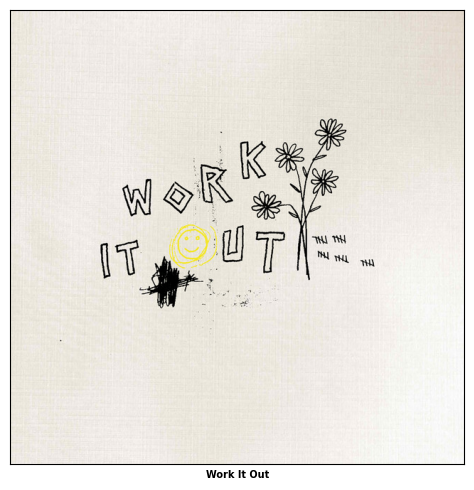

In [110]:
output = generate_recommendation(df, info, data_spotify )

track_uri = output.iloc[0]['track_id']
song = sp.track(track_uri)
visualize_cover_art([song],1)